<a href="https://colab.research.google.com/github/MSVGH1/IAD/blob/main/%D0%9B%D0%A04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

In [3]:
howpop_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/howpop_train.csv'
howpop_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/howpop_test.csv'

train_df = pd.read_csv(howpop_train_url)
test_df  = pd.read_csv(howpop_test_url)

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

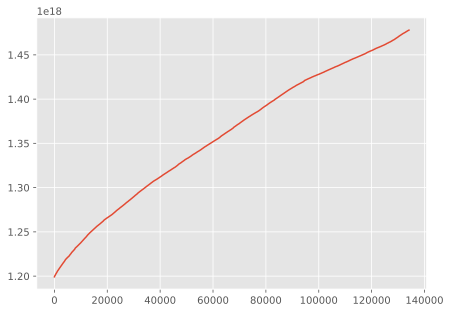

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

In [7]:
train_df.corr()

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [9]:
#Завдання 1 
train_df.published.apply(lambda ts: pd.to_datetime(ts).year).value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64

In [10]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [11]:
len(train_df), train_size

(134137, 93895)

In [12]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] # відокремлюємо ознаки від цільової змінної
X_test = test_df.loc[:, features]

In [13]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

In [14]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [15]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [16]:
X_train_title.shape

(93895, 50624)

In [17]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [19]:
#Завдання 2
X_train_title_ch.shape

(93895, 218)

In [20]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [21]:
# для початку заповнюємо пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [22]:
# Перетворимо датафрейм в словник, де ключами є індекси об'єктів (саме для цього ми транспонували датафрейм),
# а значеннями є словники у вигляді 'назва_колонки': 'значення'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [23]:
# У DictVectorizer нам потрібно буде передати список словників для кожного об'єкта у вигляді 'назва_колонки': 'значення',
# тому використовуємо .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [24]:
# У підсумку виходить розріджена матриця
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [25]:
# Але можна перетворити її в numpy array за допомогою .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [26]:
# У результуючій матриці є 5 рядків (за числом об'єктів) та 9 стовпців
# Далі розберемося чому колонок саме 9
dict_vect_matrix.shape

(5, 9)

In [27]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [30]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())


In [31]:
X_train_feats.shape 

(93895, 17869)

In [32]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch]) 

In [34]:
#Завдання 3
vectorizer_feats.vocabulary_

{'author=@Tapac': 6061,
 'flow=develop': 17865,
 'domain=habrahabr.ru': 17861,
 'author=@DezmASter': 1821,
 'flow=design': 17864,
 'author=@Taoorus': 6060,
 'author=@dennydo': 9308,
 'flow=-': 17862,
 'domain=geektimes.ru': 17860,
 'author=@lvea': 12595,
 'author=@abbasov': 7126,
 'author=@Andrey': 677,
 'flow=misc': 17868,
 'author=@kvladimir': 12229,
 'author=@caxep': 8746,
 'author=@clops': 8872,
 'author=@vasilyyaremchuk': 16732,
 'flow=management': 17866,
 'author=@suckdontbite': 15983,
 'author=@blv': 8492,
 'flow=admin': 17863,
 'author=@napster': 13486,
 'author=@hightower': 10938,
 'author=@agl666': 7237,
 'author=@Shpankov': 5639,
 'author=@calg0n': 8714,
 'author=@kudzu': 12182,
 'author=@Langraf': 3604,
 'author=@CurlyBrace': 1524,
 'author=@vladbuk': 16934,
 'author=@likegroof': 12441,
 'author=@andreikharlanov': 7740,
 'author=@meako': 12926,
 'author=@olegi': 13943,
 'author=@Astramak': 945,
 'author=@negrienko': 13533,
 'author=@vladon': 16949,
 'author=@lvader': 12594,

In [35]:
%%time
model1 = Ridge(alpha=0.1,random_state=1)
model1.fit(X_train_new, y_train)

CPU times: user 7.31 s, sys: 5.85 s, total: 13.2 s
Wall time: 7.12 s


Ridge(alpha=0.1, random_state=1)

In [40]:
%%time
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('MSE за навчальним набором: ',mean_squared_error(y_train, train_preds1))
print('MSE за валідаційним набором: ',mean_squared_error(y_valid, valid_preds1))

MSE за навчальним набором:  0.18452335504527054
MSE за валідаційним набором:  0.9036980824620631
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 35.3 ms


In [37]:
%%time
model2 = Ridge(alpha=1.0,random_state=1)
model2.fit(X_train_new, y_train)

CPU times: user 3.44 s, sys: 2.66 s, total: 6.1 s
Wall time: 3.3 s


Ridge(random_state=1)

In [41]:
%%time
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('MSE за навчальним набором: ',mean_squared_error(y_train, train_preds2))
print('MSE за валідаційним набором: ',mean_squared_error(y_valid, valid_preds2))

MSE за навчальним набором:  0.28674076626948974
MSE за валідаційним набором:  0.7010885114715637
CPU times: user 29.5 ms, sys: 0 ns, total: 29.5 ms
Wall time: 29.8 ms


In [42]:
#Завдання 4
#Середньоквадратична помилка (MSE) другої моделі за тестовим набором даних менше

In [43]:
%%time

model = Ridge()

model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y) 
test_preds = model.predict(X_test_new)

CPU times: user 5.46 s, sys: 4.3 s, total: 9.76 s
Wall time: 5.27 s


In [44]:
habr_sample_submission_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-04_popularity-ridge/habr_sample_submission.csv'

habr_sample_submission = pd.read_csv(habr_sample_submission_url, 
                                index_col='url')

In [45]:
habr_sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [46]:
ridge_submission = habr_sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds

# це буде бейзлайн "Просте рішення"
ridge_submission.to_csv('habr_ridge_baseline.csv')

In [48]:
#Завдання 5
print(test_preds)

[ 0.43435335 -1.09260971  0.65548665 ...  0.64503734  0.02541083
  0.60407764]


In [50]:
import csv

with open('habr_ridge_baseline.csv', newline='') as myFile:
    reader = csv.reader(myFile, delimiter='/', quoting=csv.QUOTE_NONE)
    for row in reader:
        print(row)

['url,favs_lognorm']
['https:', '', 'habrahabr.ru', 'post', '314080', ',0.4343533455993285']
['https:', '', 'habrahabr.ru', 'company', 'plesk', 'blog', '313732', ',-1.0926097134814443']
['https:', '', 'habrahabr.ru', 'company', 'etagi', 'blog', '314000', ',0.6554866486823754']
['https:', '', 'habrahabr.ru', 'company', 'knopka', 'blog', '314030', ',0.5183440681813845']
['https:', '', 'geektimes.ru', 'company', 'audiomania', 'blog', '282058', ',1.150439065032698']
['https:', '', 'habrahabr.ru', 'company', 'pechkin', 'blog', '314066', ',0.2789904559350769']
['https:', '', 'habrahabr.ru', 'company', 'first', 'blog', '314106', ',0.5379119921730904']
['https:', '', 'habrahabr.ru', 'company', 'vasexperts', 'blog', '313558', ',0.2332379554483296']
['https:', '', 'habrahabr.ru', 'post', '314108', ',1.659521555742516']
['https:', '', 'habrahabr.ru', 'company', 'cbs', 'blog', '313830', ',0.23740645983639064']
['https:', '', 'habrahabr.ru', 'company', 'jugru', 'blog', '313908', ',0.225914423694659